In [58]:
import torch
import random
from PIL import Image
import os
from torchvision.datasets import CIFAR10, CIFAR100, CocoCaptions, ImageNet
import slip_models
from tokenizer import SimpleTokenizer

import torchvision.transforms as T

from tqdm import tqdm
%pip install ipywidgets
%pip install update tqdm


You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [19]:
preprocess = T.Compose(
                    [
                        T.Resize(224),
                        T.CenterCrop(224),
                        T.ToTensor(),
                        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ]
                        )

In [40]:
# model = slip_models.CLIP_VITB16(embed_dim=8)
# ckpt = torch.load('ckpts/clip_embed_dim_8_epoch_35.ckpt', map_location='cpu')

model = slip_models.VisionParallelTextStandard()
ckpt = torch.load('ckpts/test_experimental_epoch_21.ckpt', map_location='cpu')
# ckpt = torch.load('tmpp_save/test_epoch_4.ckpt', map_location='cpu')


# model = slip_models.CLIP_VITB16(num_prompt_tokens=64, num_text_outputs=1000)
# ckpt = torch.load('ckpts/epoch_30_prompted_clip_may_27.ckpt', map_location='cpu')


model.load_state_dict({k.replace('module.',''):v for k,v in ckpt["model"].items()})
model = model.cuda()

In [60]:
model = slip_models.SLIP_VITB16(ssl_mlp_dim=4096, ssl_emb_dim=256)


# ckpt = torch.load('ckpts/slip_base_cc12m_35ep.pt', map_location='cpu')
ckpt = torch.load('ckpts/slip_base_100ep.pt', map_location='cpu')
model.load_state_dict({k.replace('module.',''):v for k,v in ckpt["state_dict"].items()})
model = model.cuda()

In [77]:
cc_model = slip_models.SLIP_VITB16(ssl_mlp_dim=4096, ssl_emb_dim=256)


ckpt = torch.load('ckpts/slip_base_cc12m_35ep.pt', map_location='cpu')
# ckpt = torch.load('ckpts/slip_base_100ep.pt', map_location='cpu')
cc_model.load_state_dict({k.replace('module.',''):v for k,v in ckpt["state_dict"].items()})
cc_model = cc_model.cuda()

In [44]:
tokenizer = SimpleTokenizer()

In [45]:
# image = preprocess(Image.open("pics/golden-retriever.png")).unsqueeze(0).to(device)
# image = preprocess(Image.open("pics/CLIP.png")).unsqueeze(0).to(device)
base_text = ["a diagram", "a dog", "a cat"]
model.eval()
dog_image = preprocess(Image.open("pics/golden-retriever.png"))
diagram_image = preprocess(Image.open("pics/CLIP.png").convert("RGB"))
cat_image = preprocess(Image.open("pics/cat.jpg"))
images = torch.stack([diagram_image, dog_image, cat_image]).cuda()

text = tokenizer([f"a picture of {s}" for s in base_text]).cuda()

with torch.no_grad():
    image_features = model.encode_image(images)
    text_features = model.encode_text(text)
    
    # image_features = image_features / image_features.norm(dim=1, keepdim=True)
    # text_features = text_features / text_features.norm(dim=1, keepdim=True)
    
    
    logits_per_image = model.logit_scale.exp() * image_features @ text_features.t()
    # logits_per_image, logits_per_text = model(images, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


# Basic ImageNet and CIFAR checks

In [47]:
# Download the dataset
cifar10 = CIFAR10(root="/tmp/", transform=preprocess, download=True, train=False)
loader = torch.utils.data.DataLoader(cifar10, batch_size=32, shuffle=True)
# text_inputs = torch.stack([tokenizer(f"a photo of a {c}") for c in cifar10.classes]).cuda()


text_inputs = torch.stack([tokenizer(f"a photo of a {c}") for c in cifar10.classes]).cuda()


num_correct = 0
num_seen = 0
with torch.no_grad():
    #  text_features = model.encode_text(text_inputs)
    for imgs, targets in loader:
        imgs = imgs.cuda()
        targets = targets.cuda()
        
        # image_features = model.encode_image(imgs)
        # results = model(imgs, text_inputs, lang_prompt_viz=True, sharded_computation=False)
    
        image_features = model.encode_image(imgs)
        text_features = model.encode_text(text_inputs)
        # results = model(imgs, text_inputs)
        # image_features = results['image_embed']
        # text_features = results['text_embed']
        
        
        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)
        # image_features = (image_features - image_features.mean(0)) / torch.sqrt(image_features.var(0))
        # print("Using barlow"); text_features = (text_features - text_features.mean(0)) / torch.sqrt(text_features.var(0)) 
        # image_features = (image_features - coco_image_mean) / torch.sqrt(coco_image_var)
        # print("Using barlow"); text_features = (text_features - coco_text_mean) / torch.sqrt(coco_text_var)  
        
    
        similarity = (image_features @ text_features.T).softmax(dim=-1)
        max_sims = similarity.max(dim=-1)[0]
        # print(max_sims.min(), max_sims.max(), max_sims.mean())
        num_correct += (similarity.argmax(dim=-1)==targets).sum().item()  
        num_seen += imgs.shape[0]
        curr_acc = num_correct / num_seen
        print(f"{num_seen} / {len(cifar10)} // Current Acc: {curr_acc}")
        if num_seen > 100: break
acc = num_correct / num_seen
print(f"(PARTIAL) Final Acc {acc}")

Files already downloaded and verified
32 / 10000 // Current Acc: 0.71875
64 / 10000 // Current Acc: 0.75
96 / 10000 // Current Acc: 0.6979166666666666
128 / 10000 // Current Acc: 0.6953125
(PARTIAL) Final Acc 0.6953125


In [53]:
imagenet = ImageNet(root="/export/share/datasets/vision/imagenet", transform=preprocess, split='val')
loader = torch.utils.data.DataLoader(imagenet, batch_size=32, num_workers=4, shuffle=True)
text_inputs = torch.stack([tokenizer(f"a photo of a {c}") for c in imagenet.classes]).cuda()

num_correct = 0
num_seen = 0
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)
    # print("Using barlow"); text_features = (text_features - text_features.mean(0)) / torch.sqrt(text_features.var(0))
    # print("Using barlow"); text_features = (text_features - coco_text_mean) / torch.sqrt(coco_text_var)  
    
    for imgs, targets in loader:
        imgs = imgs.cuda()
        targets = targets.cuda()
        
        image_features = model.encode_image(imgs)
        image_features = image_features / image_features.norm(dim=1, keepdim=True)
        # print("using barlow"); image_features = (image_features - image_features.mean(0)) / torch.sqrt(image_features.var(0))
        # results = model(imgs, text_inputs, lang_prompt_viz=True, sharded_computation=False)
        # image_features = results['image_embed']
        # text_features = results['text_embed']
        # image_features = (image_features - coco_image_mean) / torch.sqrt(coco_image_var) 
        
        
        similarity = (image_features @ text_features.T).softmax(dim=-1)
        num_correct += (similarity.argmax(dim=-1)==targets).sum().item()  
        max_sims = similarity.max(dim=-1)[0]
        # print(max_sims.min(), max_sims.max(), max_sims.mean())
        num_seen += imgs.shape[0]
        curr_acc = num_correct / num_seen
        print(f"{num_seen} / {len(imagenet)} // Current Acc: {curr_acc}")
        if num_seen > 1000: break
        
print(f"(PARTIAL) Final Acc {curr_acc}")

32 / 50000 // Current Acc: 0.21875
64 / 50000 // Current Acc: 0.203125
96 / 50000 // Current Acc: 0.20833333333333334
128 / 50000 // Current Acc: 0.21875
160 / 50000 // Current Acc: 0.23125
192 / 50000 // Current Acc: 0.24479166666666666
224 / 50000 // Current Acc: 0.2544642857142857
256 / 50000 // Current Acc: 0.25
288 / 50000 // Current Acc: 0.2465277777777778
320 / 50000 // Current Acc: 0.246875
352 / 50000 // Current Acc: 0.2585227272727273
384 / 50000 // Current Acc: 0.2630208333333333
416 / 50000 // Current Acc: 0.2692307692307692
448 / 50000 // Current Acc: 0.27232142857142855
480 / 50000 // Current Acc: 0.27291666666666664
512 / 50000 // Current Acc: 0.275390625
544 / 50000 // Current Acc: 0.27941176470588236
576 / 50000 // Current Acc: 0.2673611111111111
608 / 50000 // Current Acc: 0.26151315789473684
640 / 50000 // Current Acc: 0.259375
672 / 50000 // Current Acc: 0.26339285714285715
704 / 50000 // Current Acc: 0.2627840909090909
736 / 50000 // Current Acc: 0.264945652173913


In [51]:
similarity.max(1)

torch.return_types.max(
values=tensor([0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0011, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012], device='cuda:0'),
indices=tensor([ 13,  19,  19,  19,  13,  16,  19,  13, 140,  13,  13, 140,  98, 393,
        136, 136, 338, 145, 140,  16, 140, 141, 141,  98,  13,  98, 140,  20,
         13,  13, 140,  13], device='cuda:0'))

In [26]:
from torchvision import datasets, transforms

def dataset_constructor(name, split, transform):
    """
    inputs
        name: string that we'll run if/else on
        split: "train" or "val" for now
    """
    assert split in ['train', 'val']

    # Need to figure out way to override the getitem call for strong weak augmentatin
    if name == 'cifar10':
        # Has class names
        return datasets.CIFAR10(root=os.path.expanduser("~/.cache"),
                                download=True,
                                train=(split=='train'),
                               transform=transform)
    elif name == 'cifar100':
        # Has class names
        return datasets.CIFAR100(root=os.path.expanduser("~/.cache"),
                                download=True,
                                train=(split=='train'),
                                transform=transform)

    elif name == 'svhn':
        # Doesn't have class names
        return datasets.SVHN(root=os.path.expanduser("~/.cache"),
                             download=True,
                             transform=transform,
                             split=split)
    elif name == 'food101':
        # name is in .classes
        assert split=='val'
        return datasets.ImageFolder(root="/export/share/bwallace/datasets/food101/images/",
                   transform=transform)
    elif name == 'merced':
        # name is in .classes
        assert split=='val'
        return datasets.ImageFolder(root="/export/share/bwallace/datasets/UCMerced_LandUse/Images/",
                   transform=transform)
    elif name == 'dtd':
        # name is in .classes
        return datasets.ImageFolder(root=f"/export/share/bwallace/datasets/dtd/{split}",
                   transform=transform)
    elif name == 'cub':
        # name is in .classes
        return datasets.ImageFolder(root=f"/export/share/bwallace/datasets/CUB_2011_formatted/{split}",
                   transform=transform)
    elif name == 'places365':
        # class names works in 
        return datasets.Places365(
                    root="/export/share/datasets/vision/Places365/",
                    split='train-standard' if split=='train' else split,
                   transform=transform)

    elif name == 'imagenet':
        # Doesn't have class names, have separate call
        return datasets.ImageNet(
                    root="/export/share/datasets/vision/imagenet/",
                    split=split,
                   transform=transform)
    elif name == 'imagenet_val':
        assert split=='train'
        # Doesn't have class names, only use is having Imagenet val be trainset 
        return datasets.ImageNet(
                    root="/export/share/datasets/vision/imagenet/",
                    split='val',
                   transform=transform)
    else:
        raise NotImplementedError


def get_imagenet_class_dict():
        idx_to_word_id_and_name_tuple = json.load(open('imagenet_class_index.json'))
        word_id_to_name_and_idx = {v[0]:(v[1],int(k))
                           for k,v in idx_to_word_id_and_name_tuple.items()}
        # e.g. n0023923939 to ('unicorn', 123)
        return word_id_to_name_and_idx

In [27]:
def test_on_dataset(model, dataset_name, transform,
                   prompt_template="a photo of a {}",
                   test_components_mode='standard',
                   normalization_from_all_components=False):
    """
    Options for test components mode
        standard : standard
        test_all : scale through
        random_all : As all but random sorting
        
    Normalization is whether to normalize from all components or just ones in computation
    
    """
    dataset = dataset_constructor(dataset_name, 'val', transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=32, num_workers=4)
    class_names = [prompt_template.format(c.replace("'","")) for c in dataset.classes]
    
    # print(class_names)
    text_inputs = torch.stack([tokenizer(txt) for txt in class_names]).cuda()

    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)
        
        
        if test_components_mode == 'standard':
            sorted_feature_variances, sorted_variance_idx = None, None
        elif test_components_mode == 'test_all':
            sorted_feature_variances, sorted_variance_idx = sorted_feature_component_variances(text_features)
        elif test_components_mode == 'random_all':
            sorted_feature_variances, sorted_variance_idx = sorted_feature_component_variances(text_features)
            sorted_variance_idx = torch.randperm(sorted_variance_idx.shape[0])
        else:
            raise NotImplementedError
        
        num_correct = 0 if test_components_mode =='standard' else torch.zeros(text_features.shape[1])
        num_seen = 0
        for imgs, targets in tqdm(loader):
            imgs = imgs.cuda()
            targets = targets.cuda()

            image_features = model.encode_image(imgs)
            image_features = image_features / image_features.norm(dim=1, keepdim=True)
            # results = model(imgs, text_inputs, lang_prompt_viz=True, sharded_computation=False)
            # image_features = results['image_embed']
            # text_features = results['text_embed']


            if test_components_mode=="standard":
                similarity = (image_features @ text_features.T).softmax(dim=-1)
                num_correct += (similarity.argmax(dim=-1)==targets).sum().item() 
            elif test_components_mode in ["test_all", "random_all"]:
                for num_components in range(1, text_features.shape[1]+1):
                    idx_to_use = sorted_variance_idx[:num_components]
                    masked_text_features = text_features[:, idx_to_use]
                    masked_image_features = image_features[:, idx_to_use]
                    if not normalization_from_all_components:
                        masked_text_features =  masked_text_features / masked_text_features.norm(dim=1, keepdim=True)
                        masked_image_features =  masked_image_features / masked_image_features.norm(dim=1, keepdim=True)
                    masked_similarity = (masked_image_features @ masked_text_features.T).softmax(dim=-1)
                    num_correct[num_components-1] += (masked_similarity.argmax(dim=-1)==targets).sum().item()
                    
            # max_sims = similarity.max(dim=-1)[0]
            # print(max_sims.min(), max_sims.max(), max_sims.mean())
            num_seen += imgs.shape[0]
            curr_acc = num_correct / num_seen
    return curr_acc


def get_dataset_text_features(model, dataset_name, norm=True):
    dataset = dataset_constructor(dataset_name, 'val', None)
    class_names = [f"a photo of a {c}" for c in dataset.classes]
    text_inputs = torch.stack([tokenizer(txt) for txt in class_names]).cuda()
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        if norm: text_features = text_features / text_features.norm(dim=1, keepdim=True)
    return text_features

def sorted_feature_component_variances(tensor):
    # NOTE: sorting max first so [0] is intuitively important
    feature_variances = tensor.var(dim=0)
    idx = feature_variances.argsort().flip(0)
    return feature_variances[idx], idx


In [61]:
test_on_dataset(model, 'cub', preprocess,
                prompt_template="a photo of a {}, a type of bird",
                test_components_mode='standard')

100%|████████████████████████████████████████████████████████████████████████████████████████| 182/182 [00:12<00:00, 14.87it/s]


0.43872972040041425

In [ ]:
# ~0.43 for yfcc

In [29]:
tf = get_dataset_text_features(model, 'dtd', norm=True)
sorted_feature_component_variances(tf)

(tensor([0.0026, 0.0025, 0.0025, 0.0024, 0.0024, 0.0023, 0.0023, 0.0022, 0.0022,
         0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0022, 0.0021, 0.0021,
         0.0021, 0.0021, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
         0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019,
         0.0019, 0.0019, 0.0019, 0.0019, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018,
         0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018,
         0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018,
         0.0018, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
         0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
         0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
         0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0016, 0.0016,
         0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
         0.0016, 0.0016, 0.0

In [83]:
test_on_dataset(model, 'food101', preprocess, prompt_template="a photo of a {}, a type of food")

  6%|█████▌                                                                                 | 200/3157 [00:20<05:06,  9.64it/s]


KeyboardInterrupt: 

In [82]:
test_on_dataset(cc_model, 'dtd', preprocess, prompt_template="a photo of a {}, a type of food")

100%|██████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


0.23670212765957446

In [31]:
ordered_accs=test_on_dataset(model, 'cub', preprocess, test_components_mode='test_all')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182/182 [02:18<00:00,  1.32it/s]


In [37]:
ordered_accs

tensor([0.0074, 0.0093, 0.0093, 0.0116, 0.0131, 0.0124, 0.0154, 0.0131, 0.0147,
        0.0174, 0.0176, 0.0202, 0.0214, 0.0238, 0.0235, 0.0247, 0.0240, 0.0276,
        0.0302, 0.0304, 0.0242, 0.0223, 0.0226, 0.0235, 0.0202, 0.0216, 0.0209,
        0.0209, 0.0230, 0.0228, 0.0228, 0.0223, 0.0230, 0.0236, 0.0252, 0.0255,
        0.0249, 0.0268, 0.0274, 0.0287, 0.0285, 0.0259, 0.0257, 0.0250, 0.0276,
        0.0269, 0.0266, 0.0261, 0.0288, 0.0323, 0.0326, 0.0324, 0.0307, 0.0309,
        0.0311, 0.0288, 0.0333, 0.0340, 0.0345, 0.0357, 0.0362, 0.0343, 0.0354,
        0.0349, 0.0356, 0.0368, 0.0378, 0.0361, 0.0369, 0.0380, 0.0380, 0.0385,
        0.0357, 0.0380, 0.0345, 0.0335, 0.0349, 0.0321, 0.0316, 0.0330, 0.0342,
        0.0340, 0.0340, 0.0349, 0.0338, 0.0352, 0.0378, 0.0373, 0.0362, 0.0371,
        0.0387, 0.0376, 0.0387, 0.0397, 0.0397, 0.0395, 0.0392, 0.0400, 0.0400,
        0.0412, 0.0412, 0.0407, 0.0423, 0.0495, 0.0495, 0.0504, 0.0523, 0.0525,
        0.0518, 0.0516, 0.0514, 0.0501, 

In [66]:
sorted_accs  = test_on_dataset(model, 'cub', preprocess, test_components_mode='test_all',
                prompt_template="a photo of a {}, a type of bird")

100%|████████████████████████████████████████████████████████████████████████████████████████| 182/182 [00:40<00:00,  4.53it/s]


In [63]:
random_accs_1 = test_on_dataset(model, 'cub', preprocess, test_components_mode='random_all')

100%|████████████████████████████████████████████████████████████████████████████████████████| 182/182 [00:44<00:00,  4.08it/s]


In [64]:
random_accs_2 = test_on_dataset(model, 'cub', preprocess, test_components_mode='random_all')

100%|████████████████████████████████████████████████████████████████████████████████████████| 182/182 [00:44<00:00,  4.08it/s]


In [69]:
sorted_accs = sorted_variances

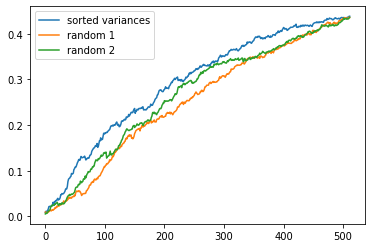

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(sorted_accs.detach().cpu().numpy(), label="sorted variances")
plt.plot(random_accs_1.detach().cpu().numpy(), label="random 1")
plt.plot(random_accs_2.detach().cpu().numpy(), label="random 2")
plt.legend()

Text(0, 0.5, 'CUB Accuracy')

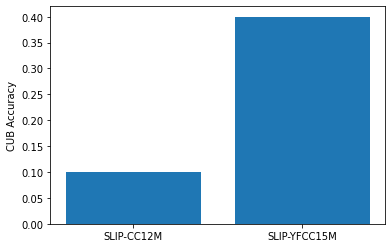

In [75]:
plt.figure()
plt.bar(range(2), [0.1, 0.4])
plt.xticks(range(2), ['SLIP-CC12M', 'SLIP-YFCC15M'])
plt.ylabel("CUB Accuracy")

Text(0, 0.5, 'DTD Accuracy')

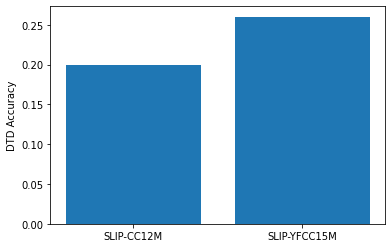

In [80]:
plt.figure()
plt.bar(range(2), [0.2, 0.26])
plt.xticks(range(2), ['SLIP-CC12M', 'SLIP-YFCC15M'])
plt.ylabel("DTD Accuracy")

In [72]:
help(plt.bar)

Help on function bar in module matplotlib.pyplot:

bar(x, height, width=0.8, bottom=None, *, align='center', data=None, **kwargs)
    Make a bar plot.
    
    The bars are positioned at *x* with the given *align*\ment. Their
    dimensions are given by *height* and *width*. The vertical baseline
    is *bottom* (default 0).
    
    Many parameters can take either a single value applying to all bars
    or a sequence of values, one for each bar.
    
    Parameters
    ----------
    x : float or array-like
        The x coordinates of the bars. See also *align* for the
        alignment of the bars to the coordinates.
    
    height : float or array-like
        The height(s) of the bars.
    
    width : float or array-like, default: 0.8
        The width(s) of the bars.
    
    bottom : float or array-like, default: 0
        The y coordinate(s) of the bars bases.
    
    align : {'center', 'edge'}, default: 'center'
        Alignment of the bars to the *x* coordinates:
    
   

In [ ]:
tf = get_dataset_text_features(model, 'food101')

In [ ]:
tf.shape

In [ ]:
tf.std(dim=0)

In [ ]:
text_features.std(dim=0).shape

In [50]:
coco_ds = CocoCaptions(root="/export/share/datasets/vision/coco/images/val2017/",
                             annFile="/export/share/datasets/vision/coco/annotations/captions_val2017.json",
                            transform=preprocess,
                            target_transform=random.choice)

loader = torch.utils.data.DataLoader(coco_ds, shuffle=False, batch_size=32)

image_features = []
text_features = []
with torch.no_grad():
    for imgs, txts in loader:
        # print(imgs.shape, txts.shape)
        imgs = imgs.cuda()
        txts = tokenizer(txts)
        txts = txts.cuda()
        image_features = model.encode_image(imgs)
        text_features = model.encode_text(txts)
        break
    

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [47]:
txts

('A person standing at a table in a room.',
 "A close up picture of a brown bear's face.",
 'This room has a bed with blue sheets and a large bookcase',
 "A stop sign is mounted upside-down on it's post. ",
 'A group of three stuffed animal teddy bears.',
 'A young woman is skiing down the mountain slope. ',
 'Kitchen appliances and cabinets as seen through opening.',
 'A couple of men play baseball and the batter runs for base.',
 'This woman has just returned a volley in tennis',
 'The people are posing for a group photo.',
 'People underneath an arched bridge near the water.',
 'A woman holding a Hello Kitty phone on her hands.',
 'Several children on a small  indoor kiddie train.',
 'A plate with a burger that is halfway eaten. ',
 'A man in a wet suit stands on a surfboard and rows with a paddle.',
 'A laptop and desktop computer on a white desk',
 'Many cars traveling on a busy road with exit signs overhead.',
 'The red, double decker bus is driving past other buses. ',
 'A black

In [52]:
coco_image_mean = image_features.mean(0)
coco_image_var = image_features.var(0)
coco_text_mean = text_features.mean(0)
coco_text_var = text_features.var(0)